In [1]:
# loading data

from astropy.table import Table
import numpy as np

path = "flamingo-data/l1_hydro_m8_dmo_m10.hdf5"

halos_tab = Table.read(path, path="halos")
parts_tab = Table.read(path, path="particles")

particle_pos = np.array(parts_tab["pos"], dtype=np.float64)
halo_pos = np.array(halos_tab["pos"], dtype=np.float64)
halo_mass = np.array(halos_tab["mtot"], dtype=np.float64)

particle_pos[:3], halo_pos[:3], halo_mass[:3]


(array([[679.64990234, 152.56231689, 658.51184082],
        [680.80114746, 158.16107178, 656.45654297],
        [679.72753906, 157.99188232, 656.80413818]]),
 array([[ 0.61892414, 16.90147781,  2.43126273],
        [12.09829617,  6.1280303 ,  6.2390399 ],
        [14.68611622, 13.9223814 , 11.92554665]]),
 array([5.11822570e+13, 1.26393600e+13, 7.03132493e+12]))

In [2]:
# fitting data to a periodic box

pmin = np.minimum(particle_pos.min(axis=0), halo_pos.min(axis=0))
pmax = np.maximum(particle_pos.max(axis=0), halo_pos.max(axis=0))
Lvec = pmax - pmin

# strict upper bound
Lvec = np.nextafter(Lvec.astype(np.float64), np.float64(np.inf))

# wrapping into [0, Lvec)
pp = (particle_pos - pmin) % Lvec
hp = (halo_pos - pmin) % Lvec

Lvec


array([680.99991414, 680.99991082, 681.        ])

In [3]:
# building the KD trees, boundry conditions, shell radii

from scipy.spatial import cKDTree

# per lange.
R_MIN, R_MAX = 6.0, 9.0

tree_all = cKDTree(pp, boxsize=Lvec)
tree_halo = cKDTree(hp, boxsize=Lvec)


In [4]:
# 5 - 20
# baseline mean=844.454, SEM=0.689, rel_err=0.08%
# halo mean=861.956, bias (overall) = 1.021
# bin 0: 	[1.025e+12,1.835e+12)  b=1.008
# bin 1: 	[1.835e+12,3.287e+12)  b=1.009
# bin 2: 	[3.287e+12,5.885e+12)  b=1.022
# bin 3: 	[5.885e+12,1.054e+13)  b=1.042
# bin 4: 	[1.054e+13,1.887e+13)  b=1.065
# bin 5: 	[1.887e+13,3.379e+13)  b=1.095
# bin 6: 	[3.379e+13,6.052e+13)  b=1.138
# bin 7: 	[6.052e+13,1.084e+14)  b=1.180
# bin 8: 	[1.084e+14,1.941e+14)  b=1.239
# bin 9: 	[1.941e+14,3.475e+14)  b=1.325
# bin 10: 	[3.475e+14,6.223e+14)  b=1.458
# bin 11: 	[6.223e+14,1.114e+15)  b=1.581

# 6 - 9
# baseline mean=64.386, SEM=0.173, rel_err=0.27%
# halo mean=67.246, bias (overall) = 1.044
# bin 0: 	[1.025e+12,1.835e+12)  b=1.015
# bin 1: 	[1.835e+12,3.287e+12)  b=1.016
# bin 2: 	[3.287e+12,5.885e+12)  b=1.049
# bin 3: 	[5.885e+12,1.054e+13)  b=1.093
# bin 4: 	[1.054e+13,1.887e+13)  b=1.151
# bin 5: 	[1.887e+13,3.379e+13)  b=1.219
# bin 6: 	[3.379e+13,6.052e+13)  b=1.317
# bin 7: 	[6.052e+13,1.084e+14)  b=1.423
# bin 8: 	[1.084e+14,1.941e+14)  b=1.587
# bin 9: 	[1.941e+14,3.475e+14)  b=1.769
# bin 10: 	[3.475e+14,6.223e+14)  b=2.075
# bin 11: 	[6.223e+14,1.114e+15)  b=2.586

In [5]:
# computing the random baseline. particles per particle. SEM give pretty good, rel error consistently far below 1%.

rng = np.random.default_rng(64)
N_RAND = 100000
BATCH = 10000

def batch_mean_shell(batch_pts):
    tb = cKDTree(batch_pts, boxsize=Lvec)
    cmax = tb.count_neighbors(tree_all, R_MAX)
    cmin = tb.count_neighbors(tree_all, R_MIN)
    return (cmax - cmin) / len(batch_pts)

means = []
n_done = 0
while n_done < N_RAND:
    n_take = min(BATCH, N_RAND - n_done)
    idx = rng.integers(0, len(pp), size=n_take)
    means.append(batch_mean_shell(pp[idx]))
    n_done += n_take

means = np.array(means)
mean_pp = means.mean()
sem_pp = means.std(ddof=1) / np.sqrt(len(means))
rel_err = sem_pp / mean_pp
print(f"baseline mean={mean_pp:.3f}, SEM={sem_pp:.3f}, rel_err={100*rel_err:.2f}%")


baseline mean=64.386, SEM=0.173, rel_err=0.27%


In [6]:
V_shell = (4.0*np.pi/3.0) * (R_MAX**3 - R_MIN**3)
V_sim = float(Lvec[0] * Lvec[1] * Lvec[2])
N_ptcl = len(pp)

expected_mean = N_ptcl * V_shell / V_sim
print(f"expected mean: {expected_mean:.3f}")

expected mean: 49.601


In [7]:
N_RAND = 100000
BATCH = 10000

# uniform in the periodic box [0, Lx) x [0, Ly) x [0, Lz)
def sample_uniform(n):
    u = rng.random((n, 3))
    return u * Lvec

def batch_mean_shell_uniform(n):
    pts = sample_uniform(n)
    tb = cKDTree(pts, boxsize=Lvec)
    cmax = tb.count_neighbors(tree_all, R_MAX)
    cmin = tb.count_neighbors(tree_all, R_MIN)
    return (cmax - cmin) / n

means = []
n_done = 0
while n_done < N_RAND:
    n_take = min(BATCH, N_RAND - n_done)
    means.append(batch_mean_shell_uniform(n_take))
    n_done += n_take

means = np.array(means)
mean_uniform = means.mean()
sem_uniform = means.std(ddof=1)/np.sqrt(len(means))
rel_err = sem_uniform / mean_uniform

print(f"Measured mean (uniform): {mean_uniform:.3f}  SEM={sem_uniform:.3f}  rel_err={100*rel_err:.2f}%")
print(f"Diff vs expected: {mean_uniform - expected_mean:.3f} ({100*(mean_uniform/expected_mean-1):.2f}%)")

Measured mean (uniform): 49.751  SEM=0.101  rel_err=0.20%
Diff vs expected: 0.149 (0.30%)


In [8]:
# computing shell neighbors around halos, bias p_halo/p_random

cmax_h = tree_halo.count_neighbors(tree_all, R_MAX)
cmin_h = tree_halo.count_neighbors(tree_all, R_MIN)
mean_ph = (cmax_h - cmin_h) / len(hp)

bias_all = (mean_ph - mean_uniform) / (mean_pp - mean_uniform)
print(f"halo mean={mean_ph:.3f}")
print(f"bias (overall) = {bias_all:.3f}")


halo mean=67.246
bias (overall) = 1.195


In [9]:
# bias versus halo mass, putting into log bins.

nbins = 12
mbins = np.logspace(np.log10(halo_mass.min()), np.log10(halo_mass.max()), nbins+1)
bin_idx = np.digitize(halo_mass, mbins) - 1

bias_bin = np.full(nbins, np.nan)
for b in range(nbins):
    sel = bin_idx == b
    if not np.any(sel):
        continue
    th = cKDTree(hp[sel], boxsize=Lvec)
    cmax = th.count_neighbors(tree_all, R_MAX)
    cmin = th.count_neighbors(tree_all, R_MIN)
    mean_ph_b = (cmax - cmin) / sel.sum()
    bias_bin[b] = (mean_ph_b - mean_uniform) / (mean_pp - mean_uniform)

for b in range(nbins):
    if np.isfinite(bias_bin[b]):
        print(f"bin {b}:   \t[{mbins[b]:.3e},{mbins[b+1]:.3e})  b={bias_bin[b]:.3f}")
    else:
        print(f"error by bin {b}")
        break

bin 0:   	[1.025e+12,1.835e+12)  b=1.064
bin 1:   	[1.835e+12,3.287e+12)  b=1.071
bin 2:   	[3.287e+12,5.885e+12)  b=1.217
bin 3:   	[5.885e+12,1.054e+13)  b=1.411
bin 4:   	[1.054e+13,1.887e+13)  b=1.666
bin 5:   	[1.887e+13,3.379e+13)  b=1.963
bin 6:   	[3.379e+13,6.052e+13)  b=2.397
bin 7:   	[6.052e+13,1.084e+14)  b=2.860
bin 8:   	[1.084e+14,1.941e+14)  b=3.582
bin 9:   	[1.941e+14,3.475e+14)  b=4.384
bin 10:   	[3.475e+14,6.223e+14)  b=5.729
bin 11:   	[6.223e+14,1.114e+15)  b=7.975


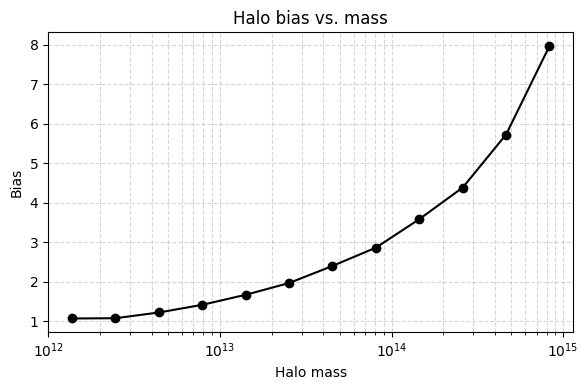

In [10]:
import matplotlib.pyplot as plt

# compute bin centers in log-space
log_mbins = np.log10(mbins)
bin_centers = 0.5 * (log_mbins[1:] + log_mbins[:-1])

# mask finite values
mask = np.isfinite(bias_bin)
x = 10**bin_centers[mask]
y = bias_bin[mask]

plt.figure(figsize=(6,4))
plt.plot(x, y, marker="o", linestyle="-", color="k")

plt.xscale("log")
plt.xlabel("Halo mass")
plt.ylabel("Bias")
plt.title("Halo bias vs. mass")

plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.savefig("bias-bins.png")
plt.show()

In [11]:
HALO_BATCH = 50000

def shell_counts(points, tree_all, rmin, rmax, batch=50000):
    counts = np.empty(len(points), dtype=np.int32)
    for i in range(0, len(points), batch):
        sub = points[i:i+batch]
        # neighbors within rmax and rmin
        idx_rmax = tree_all.query_ball_point(sub, r=rmax, workers=-1)
        if rmin > 0:
            idx_rmin = tree_all.query_ball_point(sub, r=rmin, workers=-1)
            counts[i:i+batch] = np.fromiter(
                (len(a)-len(b) for a,b in zip(idx_rmax, idx_rmin)),
                dtype=np.int32, count=len(sub)
            )
        else:
            counts[i:i+batch] = np.fromiter((len(a) for a in idx_rmax),
                                            dtype=np.int32, count=len(sub))
    return counts

halo_counts = shell_counts(hp, tree_all, R_MIN, R_MAX, batch=HALO_BATCH)
halo_counts[:5], halo_counts.mean()


(array([ 80,  27,  54,  90, 119], dtype=int32), 67.24572936386834)

In [12]:
# calculating bias per indidivual halo
b_i = (halo_counts - mean_uniform) / (mean_pp - mean_uniform)

# poly fit in log_10 mass
logM = np.log10(halo_mass)
deg = 4
coef = np.polyfit(logM, b_i, deg=deg)
p = np.poly1d(coef)

coef


array([ 5.45814536e-01, -2.86011394e+01,  5.62003914e+02, -4.90684318e+03,
        1.60595626e+04])

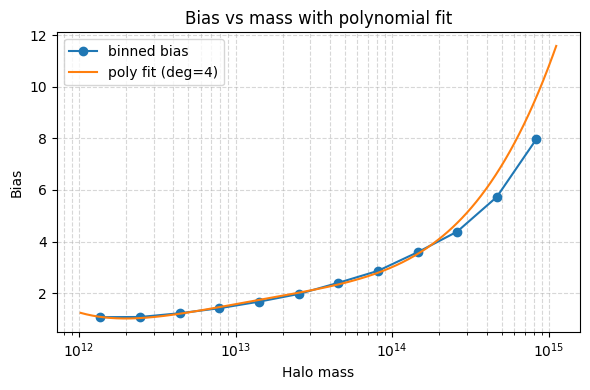

In [13]:
mask = np.isfinite(bias_bin)
x_bins = 10**bin_centers[mask]
y_bins = bias_bin[mask]

# smooth fit curve across mass range
x_fit = np.logspace(np.log10(halo_mass.min()), np.log10(halo_mass.max()), 400)
y_fit = p(np.log10(x_fit))

plt.figure(figsize=(6,4))
plt.plot(x_bins, y_bins, marker="o", linestyle="-", label="binned bias")
plt.plot(x_fit, y_fit, linestyle="-", label=f"poly fit (deg={deg})")
plt.xscale("log")
plt.xlabel("Halo mass")
plt.ylabel("Bias")
plt.title("Bias vs mass with polynomial fit")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.savefig("fit-vs-binned.png")
plt.show()


In [14]:
delta_b = b_i - p(logM)
delta_b[:5], np.nanmean(delta_b), np.nanstd(delta_b)


(array([-0.3486684 , -3.23478751, -1.11144044,  1.62019079,  3.08723334]),
 1.2874681010363911e-11,
 2.416682879812439)

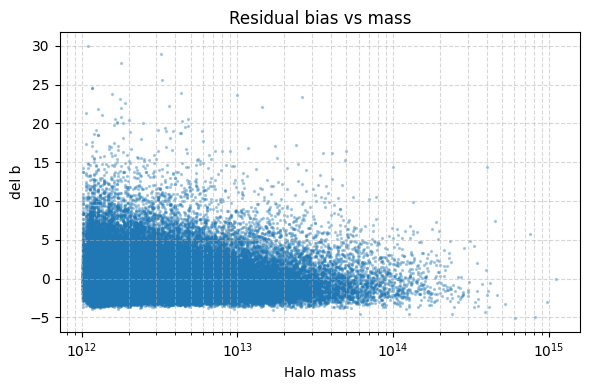

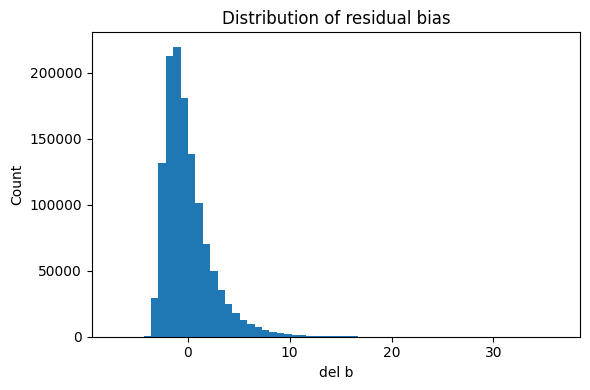

In [15]:
# scatter (downsample for visibility)
rng = np.random.default_rng(0)
show = rng.choice(len(logM), size=min(100000, len(logM)), replace=False)

plt.figure(figsize=(6,4))
plt.scatter(halo_mass[show], delta_b[show], s=2, alpha=0.3)
plt.xscale("log")
plt.xlabel("Halo mass")
plt.ylabel("del b")
plt.title("Residual bias vs mass")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.savefig("rb-v-mass.png")
plt.show()

# hist
plt.figure(figsize=(6,4))
plt.hist(delta_b, bins=60)
plt.xlabel("del b")
plt.ylabel("Count")
plt.title("Distribution of residual bias")
plt.tight_layout()
plt.savefig("dist-res.png")
plt.show()


In [16]:
x0 = np.log10(halo_mass)
x  = x0 - x0.min()
x /= x.std()
y  = b_i.astype(np.float64)

# betas  = np.arange(0, 5.01, 0.1)
# gammas = np.arange(0, 5.01, 0.1)

# def fit_linear_terms_nonneg(x, y, beta, gamma, lam=1e-3):
#     X = np.column_stack([np.ones_like(x), np.power(x, beta), np.power(x, gamma)])

#     if not np.isfinite(X).all() or not np.isfinite(y).all():
#         return None, np.inf

#     D = np.diag([0.0, 1.0, 1.0])
#     X_aug = np.vstack([X, np.sqrt(lam)*D])
#     y_aug = np.concatenate([y, np.zeros(3)])

#     coef, *_ = np.linalg.lstsq(X_aug, y_aug, rcond=None)
#     sse = float(np.sum((y - X @ coef)**2))
#     return coef, sse

# best = {"beta": None, "gamma": None, "coef": None, "sse": np.inf}
# for beta in betas:
#     for gamma in gammas:
#         if abs(beta - gamma) < 0.1:
#             continue
#         coef, sse = fit_linear_terms_nonneg(x, y, beta, gamma, lam=1e-3)
#         if sse < best["sse"]:
#             best.update({"beta": beta, "gamma": gamma, "coef": coef, "sse": sse})

# A, B, C = best["coef"]
# beta_star, gamma_star = best["beta"], best["gamma"]
# print(f"Best exponents: beta={beta_star:.2f}, gamma={gamma_star:.2f}")
# print(f"A={A:.6f}, B={B:.6f}, C={C:.6f}, SSE={best['sse']:.3e}")

A, B, C = 2.223320, -1.610179, 0.409367
beta_star, gamma_star = 0.2, 1.2

In [17]:
# Best exponents: beta=0.20, gamma=1.20
# A=2.223320, B=-1.610179, C=0.409367, SSE=7.370e+06

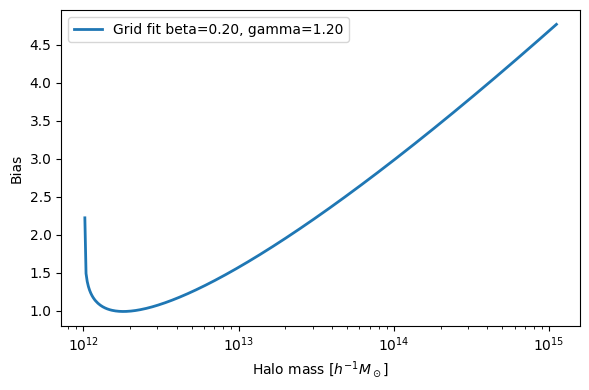

In [18]:
def b_fit_from_grid(logM_query):
    xq = (logM_query - x0.min()) / x0.std()
    return A + B*np.power(xq, beta_star) + C*np.power(xq, gamma_star)

grid = np.linspace(x0.min(), x0.max(), 400)
fit_curve = b_fit_from_grid(grid)

plt.figure(figsize=(6,4))
plt.plot(10**grid, fit_curve, linewidth=2, label=f'Grid fit beta={beta_star:.2f}, gamma={gamma_star:.2f}')
plt.xscale('log'); plt.xlabel(r'Halo mass [$h^{-1} M_\odot$]'); plt.ylabel('Bias')
plt.legend(); plt.tight_layout(); plt.show()


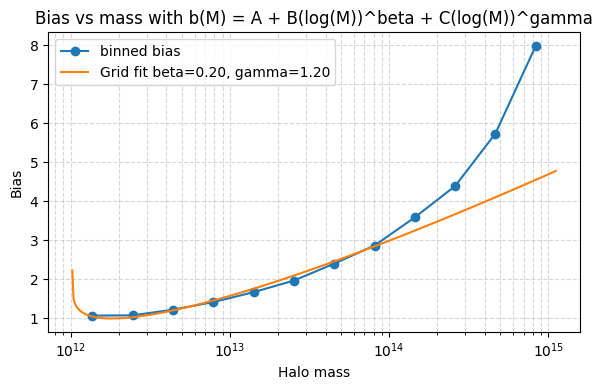

In [19]:
mask = np.isfinite(bias_bin)
x_bins = 10**bin_centers[mask]
y_bins = bias_bin[mask]

# smooth fit curve across mass range
x_fit = np.logspace(np.log10(halo_mass.min()), np.log10(halo_mass.max()), 400)
y_fit = p(np.log10(x_fit))

plt.figure(figsize=(6,4))
plt.plot(x_bins, y_bins, marker="o", linestyle="-", label="binned bias")
plt.plot(x_fit, fit_curve, linestyle="-", label=f"Grid fit beta={beta_star:.2f}, gamma={gamma_star:.2f}")
plt.xscale("log")
plt.xlabel("Halo mass")
plt.ylabel("Bias")
plt.title("Bias vs mass with b(M) = A + B(log(M))^beta + C(log(M))^gamma")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.savefig("fit-vs-binned.png")
plt.show()


In [20]:
# Inputs: x_bins = bin centers in linear mass, y_bins = binned bias values
logx_bins = np.log10(x_bins)

# Fit a polynomial in log mass
deg = 4  # or 5, depending on how flexible you want
coef = np.polyfit(logx_bins, y_bins, deg=deg)
poly = np.poly1d(coef)

# Evaluate smooth curve
grid = np.linspace(logx_bins.min(), logx_bins.max(), 400)
fit_curve = poly(grid)

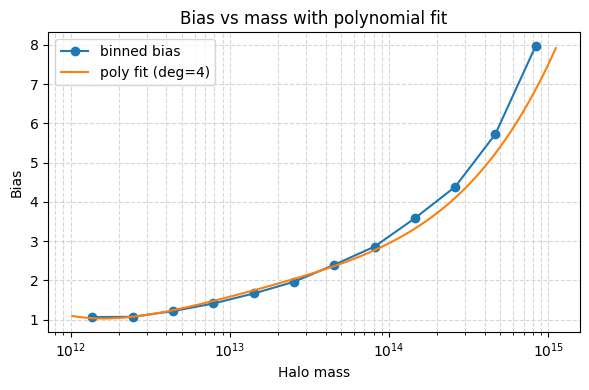

In [21]:
mask = np.isfinite(bias_bin)
x_bins = 10**bin_centers[mask]
y_bins = bias_bin[mask]

# smooth fit curve across mass range
x_fit = np.logspace(np.log10(halo_mass.min()), np.log10(halo_mass.max()), 400)
y_fit = p(np.log10(x_fit))

plt.figure(figsize=(6,4))
plt.plot(x_bins, y_bins, marker="o", linestyle="-", label="binned bias")
plt.plot(x_fit, fit_curve, linestyle="-", label=f"poly fit (deg={deg})")
plt.xscale("log")
plt.xlabel("Halo mass")
plt.ylabel("Bias")
plt.title("Bias vs mass with polynomial fit")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.savefig("fit-vs-binned.png")
plt.show()


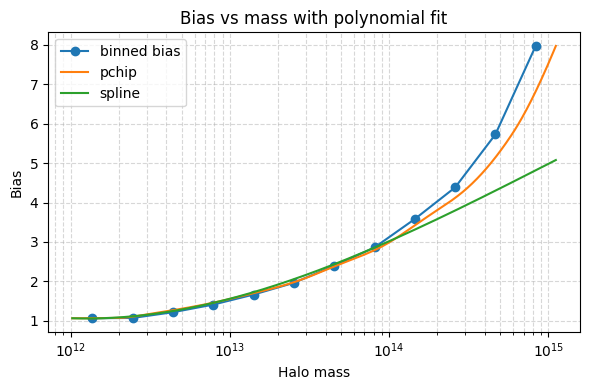

In [22]:
from scipy.interpolate import PchipInterpolator, UnivariateSpline
import numpy as np

# x_bins = bin centers in linear mass, y_bins = binned bias, err_bins = bin SEMs
xlog = np.log10(x_bins)

# Option A: monotone no-wiggle
f = PchipInterpolator(xlog, y_bins)

# Option B: smoothed spline (tune s)
w = 1/np.clip(x_bins, 1e-6, np.inf)
g = UnivariateSpline(xlog, y_bins, w=w, s=len(xlog))  # try s ~ #bins, adjust

# Evaluate for plotting/residuals
grid = np.linspace(xlog.min(), xlog.max(), 400)
fit_pchip = f(grid)
fit_spline = g(grid)

mask = np.isfinite(bias_bin)
x_bins = 10**bin_centers[mask]
y_bins = bias_bin[mask]

# smooth fit curve across mass range
x_fit = np.logspace(np.log10(halo_mass.min()), np.log10(halo_mass.max()), 400)
y_fit = p(np.log10(x_fit))

plt.figure(figsize=(6,4))
plt.plot(x_bins, y_bins, marker="o", linestyle="-", label="binned bias")
plt.plot(x_fit, fit_pchip, linestyle="-", label=f"pchip")
plt.plot(x_fit, fit_spline, linestyle="-", label=f"spline")
plt.xscale("log")
plt.xlabel("Halo mass")
plt.ylabel("Bias")
plt.title("Bias vs mass with polynomial fit")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.savefig("fit-vs-binned.png")
plt.show()


In [23]:
from astropy.table import Table
import numpy as np

path = "flamingo-data/l1_hydro_m8_dmo_m10.hdf5"

gals  = Table.read(path, path='galaxies')
halos = Table.read(path, path='halos')

is_central = (gals['type'] == b'central')

mstar = np.asarray(gals['mstar'][is_central], dtype=float)
sfr   = np.asarray(gals['sfr'][is_central],   dtype=float)
hidx  = np.asarray(gals['halo_index'][is_central], dtype=np.int64)

valid = (
    (hidx >= 0) & (hidx < len(halos)) &
    np.isfinite(mstar) & (mstar > 0) &
    np.isfinite(sfr)   & (sfr   > 0)
)

mstar = mstar[valid]
sfr   = sfr[valid]
hidx  = hidx[valid]

y = np.asarray(delta_b, dtype=float)[hidx]

logMstar = np.log10(mstar)
logsSFR  = np.log10(sfr / mstar)
X = np.column_stack([logMstar, logsSFR])

print(y.shape)
print((logMstar.shape), (logsSFR.shape))

(446847,)
(446847,) (446847,)


In [24]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=64)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(
        max_iter=500,
        early_stopping=True,
        n_iter_no_change=20,
        random_state=64
    ))
])

param_grid = {
    # "mlp__hidden_layer_sizes": [(32,), (64,), (64,32), (128,64)],
    # "mlp__activation": ["relu", "tanh"],
    # "mlp__alpha": [1e-5, 1e-4, 1e-3],
    # "mlp__learning_rate_init": [1e-3, 3e-4, 1e-4],
    # "mlp__batch_size": [256, 1024],
    "mlp__hidden_layer_sizes": [(32,)],
    "mlp__activation": ["relu"],
    "mlp__alpha": [1e-4],
    "mlp__learning_rate_init": [1e-3],
    "mlp__batch_size": [1024],
}

cv = KFold(n_splits=5, shuffle=True, random_state=64)
gs = GridSearchCV(pipe, param_grid, cv=cv, scoring="r2", n_jobs=10, verbose=1)
gs.fit(X_train, y_train)

print("R2:", gs.best_score_)
print("Best params:", gs.best_params_)

y_pred = gs.predict(X_test)
print("Test R2:", r2_score(y_test, y_pred))
print("Test MAE:", mean_absolute_error(y_test, y_pred))

best_model = gs.best_estimator_


Fitting 5 folds for each of 1 candidates, totalling 5 fits
R2: 0.0011666583077653448
Best params: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__batch_size': 1024, 'mlp__hidden_layer_sizes': (32,), 'mlp__learning_rate_init': 0.001}
Test R2: 0.001026027387983075
Test MAE: 1.7787802698351374


In [25]:
# Fitting 5 folds for each of 144 candidates, totalling 720 fits
# Best CV R2: 0.001231040199733613
# Best params: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__batch_size': 1024, 'mlp__hidden_layer_sizes': (32,), 'mlp__learning_rate_init': 0.001}
# Test R2: 0.0015634414349501302
# Test MAE: 1.7600612134252185

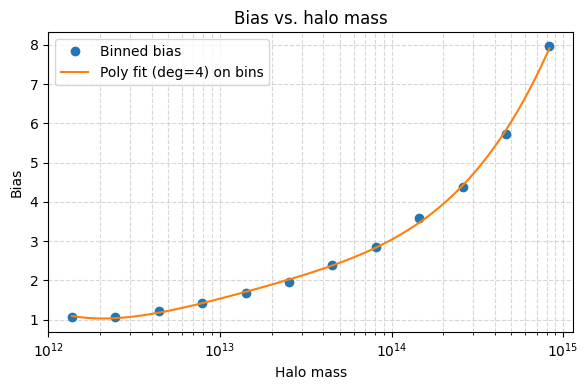

In [26]:
import numpy as np
import matplotlib.pyplot as plt

logx_bins = np.log10(x_bins)
deg = 4  # try 4 or 5
coef = np.polyfit(logx_bins, y_bins, deg=deg)
poly = np.poly1d(coef)

grid = np.linspace(logx_bins.min(), logx_bins.max(), 400)
fit_curve = poly(grid)

plt.figure(figsize=(6,4))
plt.plot(x_bins, y_bins, 'o', label='Binned bias')
plt.plot(10**grid, fit_curve, '-', label=f'Poly fit (deg={deg}) on bins')
plt.xscale('log')
plt.xlabel(r'Halo mass')
plt.ylabel('Bias')
plt.title('Bias vs. halo mass')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("binned-fit.png")
plt.show()


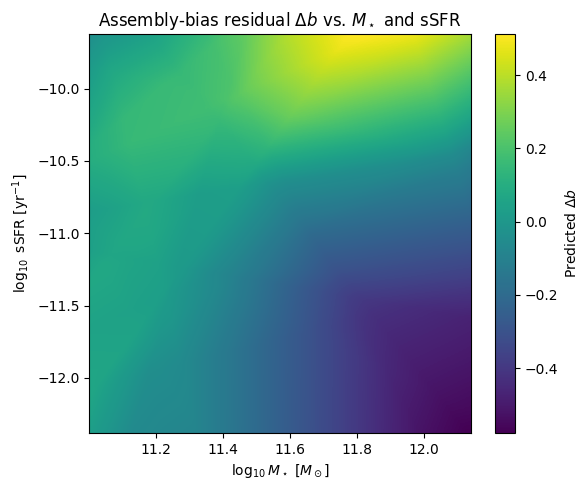

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Features used to train MLP (centrals only), and fitted model
# logMstar, logsSFR, best_model must already exist
# Define plot domain from data percentiles to avoid empty tails
mmin, mmax = np.percentile(logMstar, [1, 99])
smin, smax = np.percentile(logsSFR,  [1, 99])

# Grid
nx, ny = 200, 200
gx = np.linspace(mmin, mmax, nx)         # log10(M*)
gy = np.linspace(smin, smax, ny)         # log10(sSFR)
GX, GY = np.meshgrid(gx, gy, indexing='xy')
Xgrid = np.column_stack([GX.ravel(), GY.ravel()])

# Predict Δb on grid
Z = best_model.predict(Xgrid).reshape(ny, nx)

# Heatmap
plt.figure(figsize=(6,5))
plt.imshow(Z, origin='lower',
           extent=[gx.min(), gx.max(), gy.min(), gy.max()],
           aspect='auto')
plt.colorbar(label=r'Predicted $\Delta b$')
plt.xlabel(r'$\log_{10} M_\star\ [M_\odot]$')
plt.ylabel(r'$\log_{10}\ \mathrm{sSFR}\ [\mathrm{yr}^{-1}]$')
plt.title(r'Assembly-bias residual $\Delta b$ vs. $M_\star$ and sSFR')
plt.tight_layout()
plt.savefig("assembly-bias_residual_delb_vs_mstar_and_sSFR.png")
plt.show()

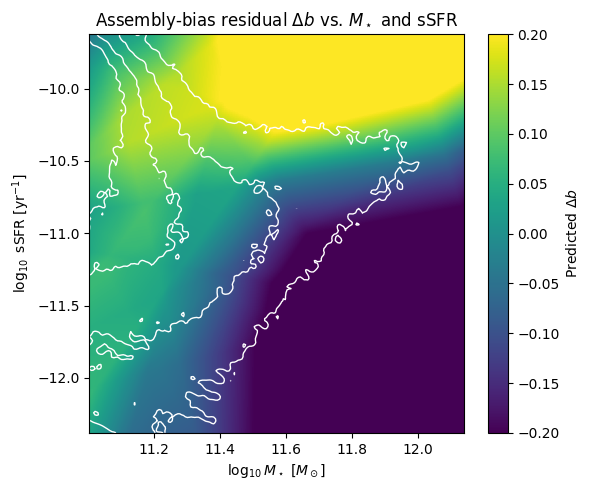

In [28]:
from scipy.ndimage import gaussian_filter

nx, ny = GX.shape[1], GX.shape[0]
x = logMstar
y = logsSFR

H, xedges, yedges = np.histogram2d(x, y,bins=[np.linspace(gx.min(), gx.max(), nx+1),np.linspace(gy.min(), gy.max(), ny+1)])

H_smooth = gaussian_filter(H.T, sigma=1.2)

levels = np.percentile(H_smooth[H_smooth>0], [50, 75, 90, 97])

# Features used to train MLP (centrals only), and fitted model
# logMstar, logsSFR, best_model must already exist
# Define plot domain from data percentiles to avoid empty tails
mmin, mmax = np.percentile(logMstar, [1, 99])
smin, smax = np.percentile(logsSFR,  [1, 99])

# Grid
nx, ny = 200, 200
gx = np.linspace(mmin, mmax, nx)         # log10(M*)
gy = np.linspace(smin, smax, ny)         # log10(sSFR)
GX, GY = np.meshgrid(gx, gy, indexing='xy')
Xgrid = np.column_stack([GX.ravel(), GY.ravel()])

# Predict Δb on grid
Z = best_model.predict(Xgrid).reshape(ny, nx)

# Heatmap
plt.figure(figsize=(6,5))
plt.imshow(Z, origin='lower',
           extent=[gx.min(), gx.max(), gy.min(), gy.max()],
           aspect='auto',
          vmin = -0.2, vmax = 0.2)
plt.colorbar(label=r'Predicted $\Delta b$')
plt.xlabel(r'$\log_{10} M_\star\ [M_\odot]$')
plt.ylabel(r'$\log_{10}\ \mathrm{sSFR}\ [\mathrm{yr}^{-1}]$')
plt.title(r'Assembly-bias residual $\Delta b$ vs. $M_\star$ and sSFR')
plt.tight_layout()
plt.contour(GX, GY, H_smooth, levels=levels, colors='white', linewidths=1.0)
plt.savefig("with-contour.png")

plt.show()


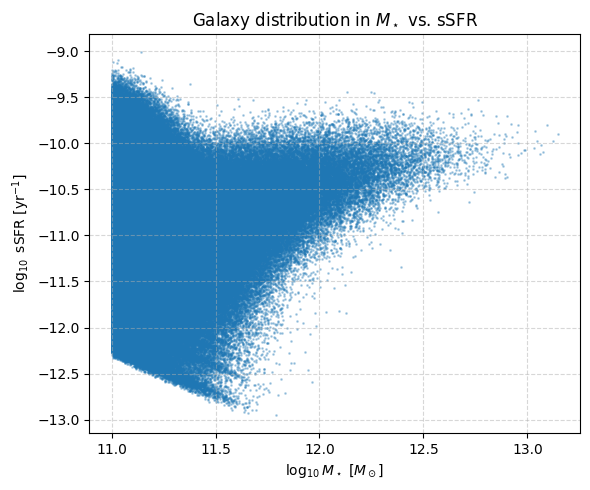

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Assume gal_mstar and gal_sfr are numpy arrays from your dataset
mstar = np.asarray(mstar, dtype=float)
sfr   = np.asarray(sfr, dtype=float)

# Filter out invalid values
mask = (mstar > 0) & (sfr > 0) & np.isfinite(mstar) & np.isfinite(sfr)
mstar = mstar[mask]
sfr   = sfr[mask]

# Log-transform
logM = np.log10(mstar)
logSFR = np.log10(sfr)
logsSFR = logSFR - logM  # specific SFR

# Plot
plt.figure(figsize=(6, 5))
plt.scatter(logM, logsSFR, s=1, alpha=0.3, rasterized=True)
plt.xlabel(r'$\log_{10} M_\star\ [M_\odot]$')
plt.ylabel(r'$\log_{10}\ \mathrm{sSFR}\ [\mathrm{yr}^{-1}]$')
plt.title('Galaxy distribution in $M_\star$ vs. sSFR')
plt.grid(True, ls='--', alpha=0.5)
plt.tight_layout()
plt.savefig("scatter_logM_logsSFR.png", dpi=150)
plt.show()


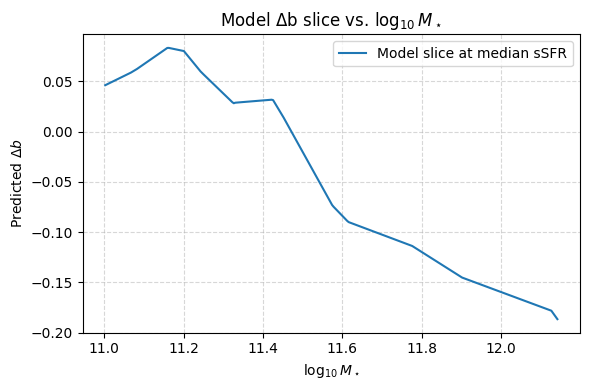

In [30]:
# Example: fix logsSFR at median, compare model curve vs. binned Δb vs. logMstar
fixed_s = np.median(logsSFR)
gx = np.linspace(np.percentile(logMstar, 1), np.percentile(logMstar, 99), 300)
curve = best_model.predict(np.column_stack([gx, np.full_like(gx, fixed_s)]))

plt.figure(figsize=(6,4))
plt.plot(gx, curve, '-', label='Model slice at median sSFR')
plt.xlabel(r'$\log_{10} M_\star$')
plt.ylabel(r'Predicted $\Delta b$')
plt.title('Model Δb slice vs. $\log_{10} M_\star$')
plt.grid(True, ls='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("model_delb_slice_vs_log10mstar.png")
plt.show()


In [31]:
y = np.asarray(delta_b, dtype=float)[hidx]

pred = best_model.predict(X)

thresh = np.median(pred)
mask_high, mask_low = pred > thresh, pred <= thresh

y_high = y[mask_high]
y_low  = y[mask_low]

n_high = y_high.size
n_low  = y_low.size

mean_high = y_high.mean()
mean_low  = y_low.mean()

diff = mean_high - mean_low

print(f"median pred: {thresh:.4f}")
print(f"high: n={n_high:7d}, delb(mean)={mean_high: .4f}")
print(f"low: n={n_low:7d}, delb(mean)={mean_low: .4f}")
print(f"diff: {diff: .4f}")


median pred: 0.0539
high: n= 223423, delb(mean)= 0.1063
low: n= 223424, delb(mean)=-0.0214
diff:  0.1277


sem high: 0.005182
sem low: 0.005171


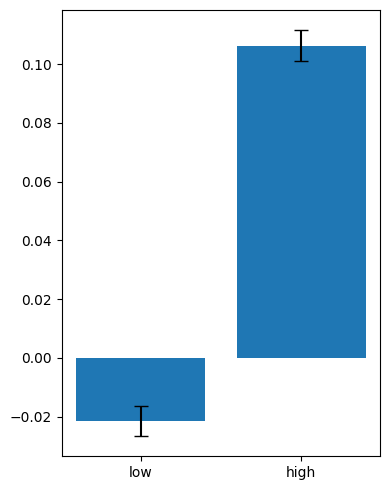

In [32]:
sem_high  = y_high.std(ddof=1) / np.sqrt(n_high)
sem_low   = y_low.std(ddof=1)  / np.sqrt(n_low)

print(f"sem high: {sem_high:.6f}")
print(f"sem low: {sem_low :.6f}")

plt.figure(figsize=(4,5))
plt.bar(["low","high"], [mean_low, mean_high],
        yerr=[sem_low, sem_high], capsize=5)
plt.tight_layout()
plt.savefig("predictions-with-error.png")
plt.show()


In [33]:
# from astropy.table import Table, join
# import numpy as np

# path1 = "flamingo-data/l1_hydro_m8_dmo_m10.hdf5"
# path2 = "flamingo-data/l1_hydro_m8_dmo_m9.hdf5"

# gals  = Table.read(path1, path='galaxies')
# halos = Table.read(path1, path='halos')

# # gals = join(gals, Table.read(path2, path='galaxies'), keys='halo_index', join_type='inner')
# # halos = join(halos, Table.read(path2, path='halos'), keys='halo_index', join_type='inner')

# is_central = (gals['type'] == b'central')

# mstar = np.asarray(gals['mstar'][is_central], dtype=float)
# sfr   = np.asarray(gals['sfr'][is_central],   dtype=float)
# hidx  = np.asarray(gals['halo_index'][is_central], dtype=np.int64)
# f_disk = np.asarray(gals["f_disk"][is_central], dtype = float)
# rhalf = np.asarray(gals["rhalf"][is_central], dtype = float)
# luminosity0 = np.asarray(gals["luminosity"][is_central][:, 0], dtype = float)
# # print(luminosity0.shape)
# luminosity1 = np.asarray(gals["luminosity"][is_central][:, 1], dtype = float)
# luminosity2 = np.asarray(gals["luminosity"][is_central][:, 2], dtype = float)
# luminosity3 = np.asarray(gals["luminosity"][is_central][:, 3], dtype = float)
# luminosity4 = np.asarray(gals["luminosity"][is_central][:, 4], dtype = float)
# luminosity5 = np.asarray(gals["luminosity"][is_central][:, 5], dtype = float)
# luminosity6 = np.asarray(gals["luminosity"][is_central][:, 6], dtype = float)
# luminosity7 = np.asarray(gals["luminosity"][is_central][:, 7], dtype = float)
# luminosity8 = np.asarray(gals["luminosity"][is_central][:, 8], dtype = float)
# metallicity = np.asarray(gals["metallicity"][is_central], dtype = float)
# msmbh = np.asarray(gals["msmbh"][is_central], dtype = float)
# age = np.asarray(gals["age"][is_central], dtype = float)

# valid = (
#     (hidx >= 0) & (hidx < len(halos)) &
#     np.isfinite(mstar) & (mstar > 0) &
#     np.isfinite(sfr)   & (sfr   > 0)
# )

# features = [mstar, sfr, f_disk, rhalf, luminosity0, luminosity1, luminosity2, luminosity3, luminosity4, luminosity5, luminosity6,
#            luminosity7, luminosity8, metallicity, msmbh, age]
# # features = [mstar, sfr, hidx, f_disk, rhalf, luminosity0, metallicity, msmbh, age]

# for i in range(len(features)):
#     features[i] = features[i][valid]


# print(y.shape)
# for feature in features:
#     print(feature.shape)

# to_log = [mstar, sfr, luminosity0, luminosity1, luminosity2,
#           luminosity3, luminosity4, luminosity5, luminosity6,
#           luminosity7, luminosity8, msmbh]
# for i in range(len(to_log)):
#     to_log[i] = np.log10(np.clip(to_log[i], 1e-10, None))


# X = np.column_stack(features)

# X = np.clip(X, np.percentile(X, 0.1, axis=0), np.percentile(X, 99.9, axis=0))

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# print(np.isnan(X_scaled).sum(axis=0))   # all should be 0
# print(np.all(np.isfinite(X_scaled)))    # should be True


# # y = np.asarray(delta_b, float)[hidx]
# mask = np.isfinite(y)
# X_scaled = X_scaled[mask]
# y = y[mask]


from astropy.table import Table
import numpy as np
from scipy.stats import rankdata

# ---- load ----
path = "flamingo-data/l1_hydro_m8_dmo_m10.hdf5"
gals  = Table.read(path, path='galaxies')
halos = Table.read(path, path='halos')

# ---- select centrals ----
is_central = (gals['type'] == b'central')
gals_c = gals[is_central]

# ---- pull columns we care about ----
# luminosity is (N, 9); we split it
lum = np.asarray(gals_c["luminosity"], float)   # shape (Nc, 9)

feat_dict = {
    "mstar":      np.asarray(gals_c["mstar"], float),
    "sfr":        np.asarray(gals_c["sfr"], float),
    "f_disk":     np.asarray(gals_c["f_disk"], float),
    "rhalf":      np.asarray(gals_c["rhalf"], float),
    "lum0":       lum[:, 0],
    "lum1":       lum[:, 1],
    "lum2":       lum[:, 2],
    "lum3":       lum[:, 3],
    "lum4":       lum[:, 4],
    "lum5":       lum[:, 5],
    "lum6":       lum[:, 6],
    "lum7":       lum[:, 7],
    "lum8":       lum[:, 8],
    "metallicity": np.asarray(gals_c["metallicity"], float),
    "msmbh":       np.asarray(gals_c["msmbh"], float),
    "age":         np.asarray(gals_c["age"], float),
}
hidx = np.asarray(gals_c["halo_index"], np.int64)

# ---- validity mask (halo exists, positive mstar/sfr) ----
valid = (
    (hidx >= 0) & (hidx < len(halos)) &
    np.isfinite(feat_dict["mstar"]) & (feat_dict["mstar"] > 0) &
    np.isfinite(feat_dict["sfr"])   & (feat_dict["sfr"]   > 0)
)

for k in feat_dict:
    feat_dict[k] = feat_dict[k][valid]
hidx = hidx[valid]

# target (must already exist): delta_b is per-halo
y = np.asarray(delta_b, float)[hidx]
mask_y = np.isfinite(y)
# apply to features too
for k in feat_dict:
    feat_dict[k] = feat_dict[k][mask_y]
y = y[mask_y]

# ---- build logMstar and mass bins ----
logM = np.log10(feat_dict["mstar"])  # keep real value for model
# 0.1 dex bins
bin_edges = np.arange(logM.min(), logM.max() + 0.1, 0.1)
bin_idx = np.digitize(logM, bin_edges) - 1

# ---- replace ALL features except logMstar by quantile within mass bin ----
# features to quantile-ize:
features_to_rank = [k for k in feat_dict.keys() if k != "mstar"]

for k in features_to_rank:
    arr = feat_dict[k]
    arr_rank = np.empty_like(arr, dtype=float)
    for b in np.unique(bin_idx):
        sel = (bin_idx == b)
        if not np.any(sel):
            continue
        # rank 1..N, then scale to 0..1
        ranks = rankdata(arr[sel], method='average')
        arr_rank[sel] = ranks / sel.sum()
    feat_dict[k] = arr_rank

# now construct X: first column = logM, rest = ranked features
X_cols = [logM] + [feat_dict[k] for k in features_to_rank]
X = np.column_stack(X_cols)

# optional: scale in the pipeline, not here
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (446847, 16)
y shape: (446847,)


In [37]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer, PowerTransformer

scalers = {
    'std': StandardScaler(),
    'minmax': MinMaxScaler(),
    'quantile': QuantileTransformer(output_distribution='normal'),
    'power': PowerTransformer()
}


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=64)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(
        max_iter = 5000,
        early_stopping=True,
        n_iter_no_change=20,
        random_state=64
    ))
])

param_grid = {
#     "mlp__hidden_layer_sizes": [(32,), (64,), (64,32), (128,64)],
#     "mlp__activation": ["relu", "tanh"],
#     "mlp__alpha": [1e-5, 1e-4, 1e-3, 0],
#     "mlp__learning_rate_init": [1e-3, 3e-4, 1e-4],
#     "mlp__batch_size": [256, 1024],
    
#     'scaler': list(scalers.values()),
#     'mlp__hidden_layer_sizes': [(32,), (64,), (128,), (128,64), (128,64,32)],
#     'mlp__activation': ['relu', 'tanh'],
#     'mlp__solver': ['adam', 'lbfgs'],
#     'mlp__alpha': [1e-5, 1e-4, 1e-3, 1e-2],
#     'mlp__learning_rate_init': [1e-3, 3e-4, 1e-4],
#     "mlp__batch_size": [256, 1024],

#     'scalar': [QuantileTransformer(output_distribution="normal")],
    'mlp__activation': ['relu'], 
    'mlp__alpha': [.0001], 
    'mlp__batch_size': [1024], 
    'mlp__hidden_layer_sizes': [(128, 64)], 
    'mlp__learning_rate_init': [0.001]
}

cv = KFold(n_splits=5, shuffle=True, random_state=64)
gs = GridSearchCV(pipe, param_grid, cv=cv, scoring="r2", n_jobs=60, verbose=1)
gs.fit(X_train, y_train)

print("R2:", gs.best_score_)
print("Best params:", gs.best_params_)

y_pred = gs.predict(X_test)
print("Test R2:", r2_score(y_test, y_pred))
print("Test MAE:", mean_absolute_error(y_test, y_pred))

# best_model = gs.best_estimator_

# best_scaler = grid.best_estimator_.named_steps['scaler']
# print("Best scaler:", type(best_scaler).__name__)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
R2: 0.010703802202728397
Best params: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__batch_size': 1024, 'mlp__hidden_layer_sizes': (128, 64), 'mlp__learning_rate_init': 0.001}
Test R2: 0.012599218702076587
Test MAE: 1.7714058469555798


AttributeError: 'numpy.ndarray' object has no attribute 'best_estimator_'

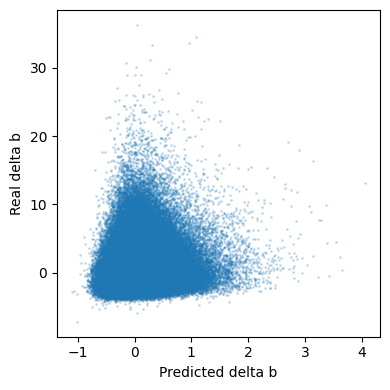

In [38]:
pred = best_model.predict(X)
plt.figure(figsize=(4,4))
plt.scatter(pred, y, s=1, alpha=0.2)
plt.ylabel("Real delta b"); plt.xlabel("Predicted delta b"); plt.tight_layout(); plt.savefig("prediction-vs-real-raw.png"); plt.show()

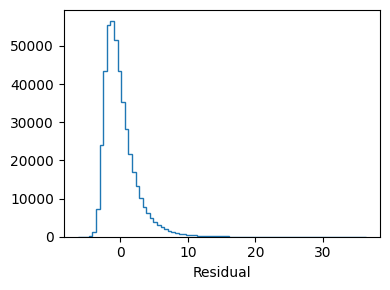

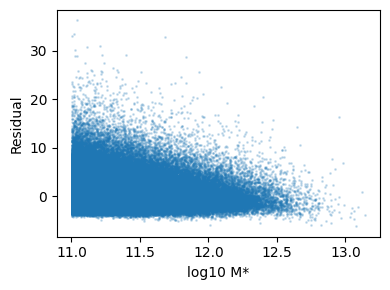

In [39]:
r = y - pred
plt.figure(figsize=(4,3)); plt.hist(r, bins=80, histtype='step'); plt.xlabel('Residual'); plt.tight_layout(); plt.savefig("remaining-residual-binned.png"); plt.show()

plt.figure(figsize=(4,3)); plt.scatter(logMstar, r, s=1, alpha=0.2)
plt.xlabel('log10 M*'); plt.ylabel('Residual'); plt.tight_layout(); plt.savefig("remaining-residual-raw.png"); plt.show()


In [40]:
from sklearn.inspection import permutation_importance
r = permutation_importance(best_model, X, y, n_repeats=5, random_state=64, scoring='r2')
idx = np.argsort(r.importances_mean)[::-1]
for j in idx[:10]:
    print(j, r.importances_mean[j], r.importances_std[j])


13 0.051087249727150084 0.0006266254698700058
2 0.03578169497525643 0.0004950130603797836
15 0.021472216416158086 0.00022831821627021707
3 0.013011925195349217 0.00017884999974802725
14 0.010808942647972941 0.00018200612189374745
8 0.010270147475437152 0.00016781265340050665
0 0.009642147876251662 0.0001531474699535396
12 0.008500758450152301 0.00014054836650014588
6 0.004764188244638623 0.00015068997228906121
7 0.004255048816291152 0.00011044461972485302


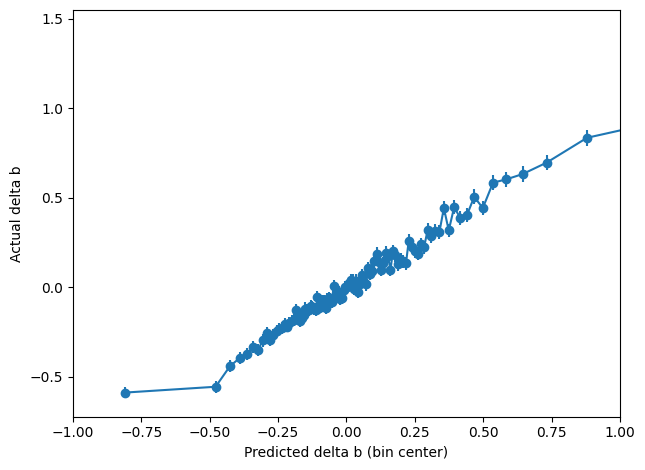

In [41]:
q = np.quantile(pred, np.linspace(0,1,101))
digit = np.digitize(pred, q)-1
m, s, c = [], [], []
for k in range(100):
    sel = digit==k
    if sel.any():
        v = y[sel]; m.append(v.mean()); s.append(v.std(ddof=1)/np.sqrt(sel.sum())); c.append((q[k]+q[k+1])/2)
plt.errorbar(c, m, yerr=s, fmt='o-'); plt.xlabel('Predicted delta b (bin center)'); plt.ylabel('Actual delta b'); plt.tight_layout(); plt.xlim(-1, 1); plt.savefig("prediction-vs-real-binned.png"); plt.show()


In [ ]:
# Fitting 5 folds for each of 1 candidates, totalling 5 fits
# R2: 0.01169132803808659
# Best params: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__batch_size': 1024, 'mlp__hidden_layer_sizes': (32,), 'mlp__learning_rate_init': 0.001}
# Test R2: 0.013959976654967288
# Test MAE: 1.768490529098173

# Fitting 5 folds for each of 144 candidates, totalling 720 fits
# R2: 0.012798837208908509
# Best params: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__batch_size': 1024, 'mlp__hidden_layer_sizes': (128, 64), 'mlp__learning_rate_init': 0.001}
# Test R2: 0.014906527444076612
# Test MAE: 1.7675948240892232

In [42]:
import shap

# background
rng = np.random.default_rng(64)
bg_size = 200
bg_idx = rng.integers(0, X.shape[0], size=bg_size)
X_bg = X[bg_idx]

# to explain
test_size = 500
test_idx = rng.integers(0, X.shape[0], size=test_size)
X_explain = X[test_idx]

f = best_model.predict

explainer = shap.KernelExplainer(f, X_bg)

shap_values = explainer.shap_values(X_explain)


/home/hg0276a-hpc/myenv39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [02:47<00:00,  2.98it/s]


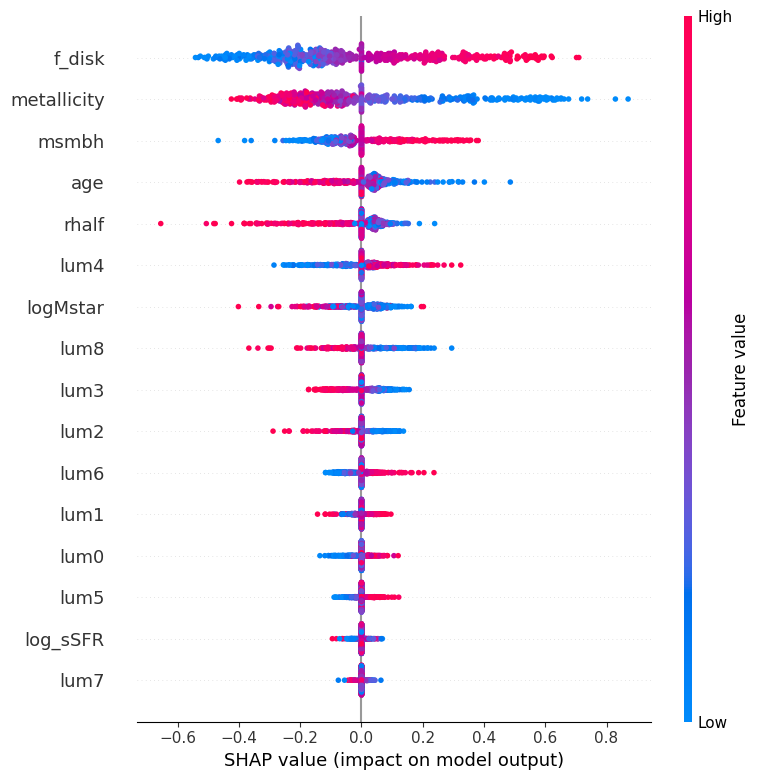

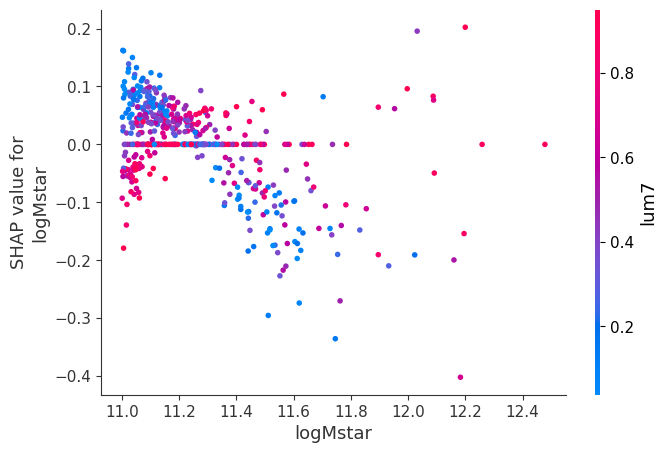

In [43]:
feature_names = [
    "logMstar", "log_sSFR", "f_disk", "rhalf",
    "lum0","lum1","lum2","lum3","lum4","lum5","lum6","lum7","lum8",
    "metallicity","msmbh","age"
][:X.shape[1]]

shap.summary_plot(shap_values, X_explain, feature_names=feature_names)

shap.dependence_plot("logMstar", shap_values, X_explain, feature_names=feature_names)


In [45]:
import joblib

best_model = gs.best_estimator_
joblib.dump(best_model, "mlp_ranked.pkl")


['mlp_ranked.pkl']

In [46]:
bg_idx = rng.integers(0, X.shape[0], size=1000)
X_bg = X[bg_idx]

best_model = joblib.load("mlp_ranked.pkl")
explainer = shap.KernelExplainer(best_model.predict, X_bg)

test_idx = rng.integers(0, X.shape[0], size=500)
X_explain = X[test_idx]
shap_values = explainer.shap_values(X_explain)


Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [10:21<00:00,  1.24s/it]


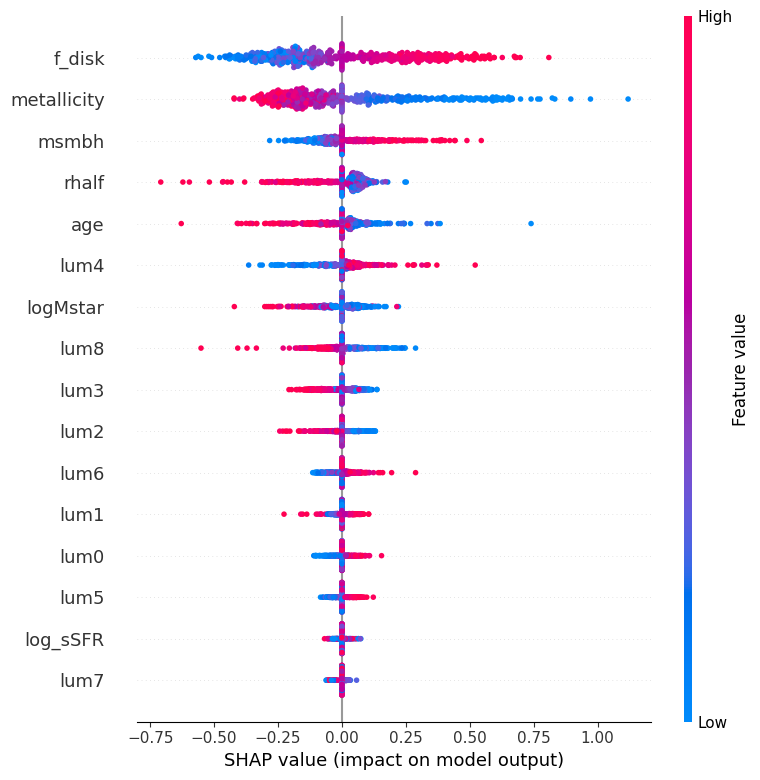

In [47]:
shap.summary_plot(shap_values, X_explain, feature_names=feature_names)
